# Layoffs in 2022

---
author: Laura Rosok
date: October 11, 2024
embed-resources: true
---

## Introduction

This model predicts the number of layoffs that will occur in a company based on the country, specific location, industry, date, business stage, and funds raised. The model is trained on a dataset of 2,255 companies that have experienced layoffs in 2022. The dataset comes from Kaggle and is available [here](https://www.kaggle.com/datasets/swaptr/layoffs-2022).

## Methods

In [32]:
# imports

import pandas as pd
import kagglehub
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### Data

In [33]:
# load data

path = kagglehub.dataset_download("swaptr/layoffs-2022")
csv_file = next(file for file in os.listdir(path) if file.endswith('.csv'))
data = pd.read_csv(os.path.join(path, csv_file), parse_dates=['date'])
data = data.drop(['percentage_laid_off', 'company'], axis=1)

data

,location,industry,total_laid_off,date,stage,country,funds_raised
0,SF Bay Area,Data,69.0,2024-10-15,Acquired,United States,23.0
1,Jakarta,Consumer,500.0,2024-10-11,Unknown,Indonesia,9400.0
2,Bengaluru,Sales,NaN,2024-10-11,Series A,India,17.0
3,Chicago,Recruiting,200.0,2024-10-10,Acquired,United States,NaN
4,Louisville,Retail,NaN,2024-10-10,Seed,United States,8.0
...,...,...,...,...,...,...,...
3823,Los Angeles,Travel,NaN,2020-03-16,Seed,United States,5.1
3824,Los Angeles,Transportation,8.0,2020-03-13,Unknown,United States,45.0
3825,SF Bay Area,Consumer,6.0,2020-03-13,Seed,United States,1.0
3826,Los Angeles,Retail,20.0,2020-03-12,Series C,United States,90.0


In [34]:
# summary statistics

data.info()

# removing null values if 10% or more is missing
for column in data.columns:
    missing_percentage = (data[column].isnull().sum()) / data[column].count() * 100
    if missing_percentage >= 10:  
        print(f"{column} should drop null values (missing: {missing_percentage:.2f}%)")
data = data.dropna(subset=['total_laid_off','funds_raised'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   location        3827 non-null   object        
 1   industry        3827 non-null   object        
 2   total_laid_off  2499 non-null   float64       
 3   date            3828 non-null   datetime64[ns]
 4   stage           3821 non-null   object        
 5   country         3828 non-null   object        
 6   funds_raised    3409 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 209.5+ KB
total_laid_off should drop null values (missing: 53.18%)
funds_raised should drop null values (missing: 12.29%)


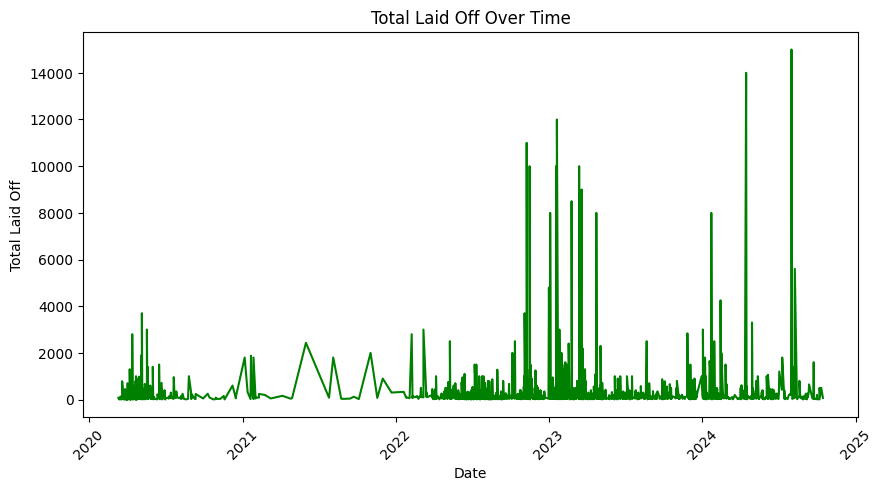

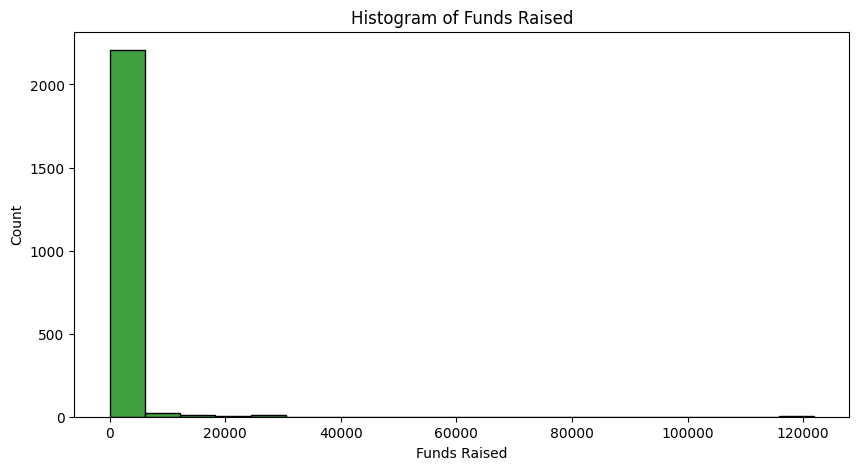

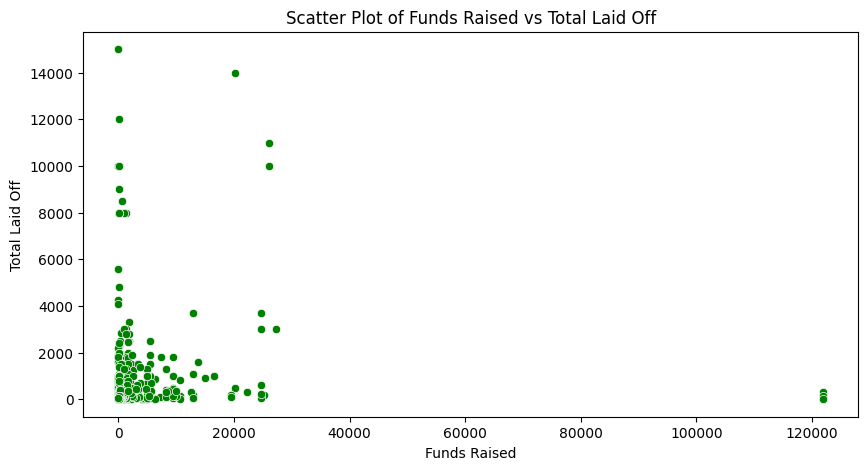

In [35]:
# visualizations

# line plot
plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['total_laid_off'], color='green')
plt.xlabel('Date')
plt.ylabel('Total Laid Off')
plt.title('Total Laid Off Over Time')
plt.xticks(rotation=45)
plt.show()

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data['funds_raised'], bins=20, color='green')
plt.xlabel('Funds Raised')
plt.ylabel('Count')
plt.title('Histogram of Funds Raised')
plt.show()

# Scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x='funds_raised', y='total_laid_off', data=data, color='green')
plt.xlabel('Funds Raised')
plt.ylabel('Total Laid Off')
plt.title('Scatter Plot of Funds Raised vs Total Laid Off')
plt.show()


### Models

In [36]:
# process data for ML

X = data.drop('total_laid_off', axis=1)
y = data['total_laid_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
numeric_features = X_train.select_dtypes(['int', 'float']).columns.tolist()
cat_features = X_train.select_dtypes(['category', 'object']).columns.tolist()

# pipeline for numeric
Numeric_pipeline = Pipeline(steps=[
    ('MedianImputer', SimpleImputer(strategy='median')),
    ('Standardize', StandardScaler())
])
# pipeline for categorical
Categorical_pipeline = Pipeline(steps=[
    ('ModalImputer', SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=5))
])

# column transformer
preprocessor = ColumnTransformer(transformers=[
        ('Numeric_processing', Numeric_pipeline, numeric_features),
        ('Categorical_processing', Categorical_pipeline, cat_features)
    ]
)

# full pipline
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DummyRegressor())

    ]
)

baseline_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('knn', LinearRegression())

    ]
)

In [38]:
# create simple param grid for baseline testing

baseline_param_grid = {}

# create param grid for all models
param_grid = [
    {
        "regressor": [DummyRegressor()],
    },
    {
        "regressor": [LinearRegression()],
    },
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    },
    {
    "regressor": [GradientBoostingRegressor(random_state=42)],
    "regressor__n_estimators": [100, 200, 500],
    "regressor__learning_rate": [0.01, 0.1, 0.05],
    "regressor__max_depth": [3, 5, 7],
},
{
    "regressor": [RandomForestRegressor(random_state=42)],
    "regressor__n_estimators": [100, 200, 500],  
    "regressor__max_depth": [None, 5, 10, 20],   
    "regressor__min_samples_leaf": [1, 2, 4],    
},
    {
        "regressor": [DecisionTreeRegressor(random_state=42)],
        "regressor__max_depth": [1, 3, 5, 7, 9, 11, 15, None],
    }
]

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numeric_processing',
                                                  Pipeline(steps=[('MedianImputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize',
                                                                   StandardScaler())]),
                                                  ['funds_raised']),
                                                 ('Categorical_processing',
                                                  Pipeline(steps=[('ModalImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=5))]),
                                                  ['location', 'industry',
                                                   'stage', 'country'])])),
                ('regressor', DummyRegressor())])

In [39]:
# baseline model

baseline_mod = GridSearchCV(
    baseline_pipeline,
    param_grid=baseline_param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error",

)

# Fit the model on the training data
baseline_mod.fit(X_train, y_train)

# Predict on the training set
baseline_train_y_pred = baseline_mod.predict(X_train)

# Predict on the test set
baseline_test_y_pred = baseline_mod.predict(X_test)

# Calculate RMSE on the training set
baseline_train_rmse = root_mean_squared_error(y_train, baseline_train_y_pred)

# Calculate RMSE on the test set
baseline_test_rmse = root_mean_squared_error(y_test,  baseline_test_y_pred)

# Print the results
if baseline_train_rmse < baseline_test_rmse:
    print("Based on RMSE, the model is overfitting.\n")
elif baseline_train_rmse > baseline_test_rmse:
    print("Based on RMSE, the model is underfitting.\n")
else:
    print("Based on RMSE, the model is neither overfitting nor underfitting.\n")

print(f"Training Root Mean Squared Error: {baseline_train_rmse}")
print(f"Test Root Mean Squared Error: {baseline_test_rmse}")

Based on RMSE, the model is underfitting.

Training Root Mean Squared Error: 864.7489595438637
Test Root Mean Squared Error: 703.137341881068


In [40]:
# train models 

mod = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error"
)

mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
train_y_pred = mod.predict(X_train)

mod

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('Numeric_processing',
                                                                         Pipeline(steps=[('MedianImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('Standardize',
                                                                                          StandardScaler())]),
                                                                         ['funds_raised']),
                                                                        ('Categorical_processing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',...
                          'regressor__max_depth': [3, 5, 7],
                          'regressor__n_estimators': [100, 200, 500]},
                         {'regressor': [RandomForestRegressor(random_state=42)],
                          'regressor__max_depth': [None, 5, 10, 20],
                          'regressor__min_samples_leaf': [1, 2, 4],
                          'regressor__n_estimators': [100, 200, 500]},
                         {'regressor': [DecisionTreeRegressor(random_state=42)],
                          'regressor__max_depth': [1, 3, 5, 7, 9, 11, 15,
                                                   None]}],
             scoring='neg_mean_squared_error')

## Results

In [41]:
# report model metrics


# Calculate RMSE on the training set
train_rmse = root_mean_squared_error(y_train, train_y_pred)

# Calculate RMSE on the test set
test_rmse = root_mean_squared_error(y_test, y_pred)


# Determine if over- or under-fitting
if train_rmse < test_rmse:
    print("Based on RMSE, the model is overfitting.\n")
elif train_rmse > test_rmse:
    print("Based on RMSE, the model is underfitting.\n")
else:
    print("Based on RMSE, the model is neither overfitting nor underfitting.\n")

# Print the train and test RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Based on RMSE, the model is underfitting.

Train RMSE: 790.401427656597
Test RMSE: 725.1739223181214


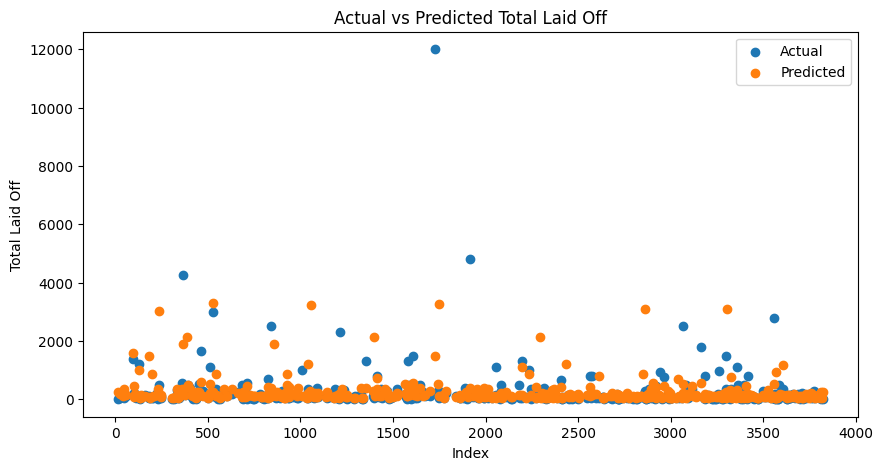

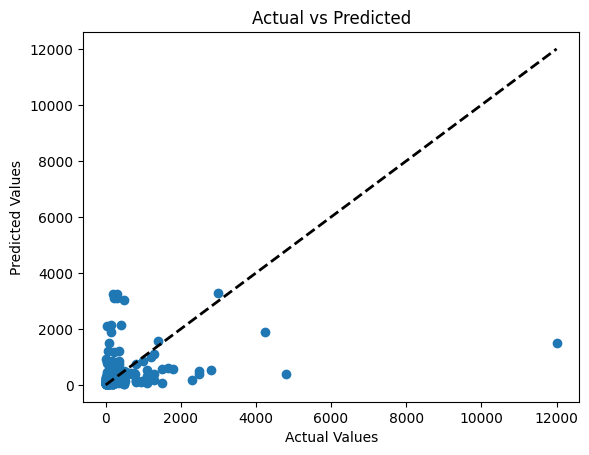

In [42]:
# plot results

plt.figure(figsize=(10, 5))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Total Laid Off')
plt.title('Actual vs Predicted Total Laid Off')
plt.legend()
plt.show()

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

## Discussion

The current model is underfitting (the train RMSE is larger than the test RMSE). This could be due to the fact that the model is too simple to capture the complexity of the data. More advanced models, such as neural networks, could be used to improve the performance of the model.